In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os

## **Utilities**

In [3]:
# Saving results
def save_image(image, file_path, c='gray'):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.imsave(file_path, image, cmap=c)
    
# Plotting resuklts
def plot_results(gray, binary_image, result_image, path, color='gray', save=False):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    ax = axes.ravel()

    ax[0].imshow(gray, cmap='gray')
    ax[0].set_title('Grayscale Image')

    ax[1].imshow(binary_image, cmap='gray')
    ax[1].set_title('Binary Image')

    ax[2].imshow(result_image, cmap='nipy_spectral')
    ax[2].set_title(f'Result Image')

    if save == True:
        save_image(gray, file_path=f'{path.split(".")[0]}/Grayscale-Image-{path.split(".")[0]}.png')
        save_image(binary_image, file_path=f'{path.split(".")[0]}/Binary-Image-{path.split(".")[0]}.png')
        save_image(result_image, file_path=f'{path.split(".")[0]}/Result-Image-{path.split(".")[0]}.png', c=color)

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

## **Image processing functions**

In [4]:
def rgb_to_gray(rgb_image):
    if rgb_image.ndim == 3:
        r_coeff = 0.299
        g_coeff = 0.587
        b_coeff = 0.114
        gray_image = np.dot(rgb_image[...,:3], [r_coeff, g_coeff, b_coeff])
        return gray_image
    return f'The image has only {rgb_image.ndim}'

def gray_to_binary(image):
    if (image.min() and image.max) in range(0,1):
        binary_image = image > 0.5
    else:
        image = image/255.0
        binary_image = image > 0.5 
    return (binary_image).astype(np.uint8)

# Function for findin threshold for binarization using otsu's method
def otsu_threshold(image):
    min_value = np.min(image)
    max_value = np.max(image)
    # Compute histogram of the grayscale image
    hist, bin_edges = np.histogram(image, bins=256, range=(min_value, max_value))
    
    total = hist.sum()
    current_max, threshold = 0, 0
    sum_total, sum_background = 0, 0
    weight_background, weight_foreground = 0, 0

    for i in range(0, len(hist)):
        sum_total += i * hist[i]
    
    for i in range(0, len(hist)):
        weight_background += hist[i]
        if weight_background == 0:
            continue
        weight_foreground = total - weight_background
        if weight_foreground == 0:
            break
        sum_background += i * hist[i]
        mean_background = sum_background / weight_background
        mean_foreground = (sum_total - sum_background) / weight_foreground
        between_class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
        if between_class_variance > current_max:
            current_max = between_class_variance
            threshold = i
    
    return bin_edges[threshold]

## **Operations**

In [5]:
# Structuring element
def disk(radius):
    L = np.arange(-radius, radius+1)
    X, Y = np.meshgrid(L, L)
    return (X**2 + Y**2) <= radius**2

# Erosion
def binary_erosion(image, selem):
    pad_width = selem.shape[0] // 2
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+selem.shape[0], j:j+selem.shape[1]]
            output[i, j] = np.min(region[selem])
    return output

# Dilation
def binary_dilation(image, selem):
    pad_width = selem.shape[0] // 2
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+selem.shape[0], j:j+selem.shape[1]]
            output[i, j] = np.max(region[selem])
    return output

def binary_opening(image, selem):
    eroded = binary_erosion(image, selem)
    return binary_dilation(eroded, selem)

def binary_closing(image, selem):
    dilated = binary_dilation(image, selem)
    return binary_erosion(dilated, selem)

## **Advanced Operations**

In [6]:
def morphological_gradient(binary_image, selem):
    erosion = binary_erosion(binary_image, selem)
    dilation = binary_dilation(binary_image, selem)
    gradient = dilation - erosion
    return gradient

In [7]:
# Guo-Hall skeletonization algorithm
def skeletonization(binary_image):
    skeleton = np.zeros_like(binary_image)
    skeleton[binary_image > 0] = 1
    
    while True:
        marker_points = []
        # Step 1
        for i in range(1, skeleton.shape[0] - 1):
            for j in range(1, skeleton.shape[1] - 1):
                if skeleton[i, j] == 0:
                    continue
                
                neighbor = [skeleton[i-1, j], skeleton[i-1, j+1], skeleton[i, j+1],
                            skeleton[i+1, j+1], skeleton[i+1, j], skeleton[i+1, j-1],
                            skeleton[i, j-1], skeleton[i-1, j-1]]
                
                # Step 2
                P = sum([1 if neighbor[k] == 0 and neighbor[(k+1) % 8] == 1 else 0 for k in range(8)])
                
                # Step 3
                if P == 1:
                    Q = sum(neighbor)
                    if Q >= 2 and Q <= 6:
                        if neighbor[0] * neighbor[2] * neighbor[4] == 0:
                            if neighbor[2] * neighbor[4] * neighbor[6] == 0:
                                marker_points.append((i, j))
        
        # Step 4
        for point in marker_points:
            skeleton[point] = 0
        
        # Step 5
        for i in range(1, skeleton.shape[0] - 1):
            for j in range(1, skeleton.shape[1] - 1):
                if skeleton[i, j] == 1:
                    neighbor = [skeleton[i-1, j], skeleton[i-1, j+1], skeleton[i, j+1],
                                skeleton[i+1, j+1], skeleton[i+1, j], skeleton[i+1, j-1],
                                skeleton[i, j-1], skeleton[i-1, j-1]]
                    
                    # Step 6
                    P = sum([1 if neighbor[k] == 0 and neighbor[(k+1) % 8] == 1 else 0 for k in range(8)])
                    
                    # Step 7
                    if P == 1:
                        Q = sum(neighbor)
                        if Q >= 2 and Q <= 6:
                            if neighbor[0] * neighbor[2] * neighbor[6] == 0:
                                if neighbor[0] * neighbor[4] * neighbor[6] == 0:
                                    skeleton[i, j] = 0
        
        # Check for termination
        if not np.any(marker_points):
            break
    
    return skeleton

In [8]:
def label_regions(binary_image, structuring_element):
    labeled_image = np.zeros_like(binary_image)
    current_label = 1  
    labels = {}  
    for r in range(binary_image.shape[0]):
        for c in range(binary_image.shape[1]):
            if binary_image[r, c] == 1 and labeled_image[r, c] == 0:
                labeled_image[r, c] = current_label
                stack = [(r, c)]
                while stack:
                    current_pixel = stack.pop()
                    neighbors = [(current_pixel[0]-1, current_pixel[1]),
                                 (current_pixel[0]+1, current_pixel[1]),
                                 (current_pixel[0], current_pixel[1]-1),
                                 (current_pixel[0], current_pixel[1]+1)]
                    for neighbor in neighbors:
                        nr, nc = neighbor
                        if 0 <= nr < binary_image.shape[0] and 0 <= nc < binary_image.shape[1]:
                            if binary_image[nr, nc] == 1 and labeled_image[nr, nc] == 0:
                                labeled_image[nr, nc] = current_label
                                stack.append((nr, nc))
                labels[current_label] = current_label
                current_label += 1
    for label in labels:
        labeled_image[labeled_image == label] = labels[label]
    
    num_labels = len(labels)
    return labeled_image, num_labels

In [9]:
# Connected component labeling
def connected_components(bin_img):
    labeled_img = np.zeros(bin_img.shape, dtype=int)
    label = 0
    max_label = 0
    equivalences = []
    
    for r in range(1, bin_img.shape[0]-1):
        for c in range(1, bin_img.shape[1]-1):
            if bin_img[r, c] == 1:
                neighbors = [labeled_img[r-1, c], labeled_img[r, c-1], labeled_img[r-1, c-1], labeled_img[r-1, c+1]]
                non_zero_neighbors = [label for label in neighbors if label > 0]
                
                if not non_zero_neighbors:
                    label += 1
                    labeled_img[r, c] = label
                else:
                    min_label = min(non_zero_neighbors)
                    labeled_img[r, c] = min_label
                    for neighbor in non_zero_neighbors:
                        if neighbor != min_label:
                            equivalences.append((neighbor, min_label))
    
    # Resolve equivalences
    def resolve_label(label, equivalence_dict):
        while label in equivalence_dict:
            label = equivalence_dict[label]
        return label
    
    equivalence_dict = {a: b for a, b in equivalences}
    for r in range(bin_img.shape[0]):
        for c in range(bin_img.shape[1]):
            if labeled_img[r, c] > 0:
                labeled_img[r, c] = resolve_label(labeled_img[r, c], equivalence_dict)
    
    unique_labels = np.unique(labeled_img)
    num_objects = len(unique_labels[unique_labels > 0])
    
    return labeled_img, num_objects

## **Erosion Operation**

**Objective**: Perform binary erosion on a binary image.

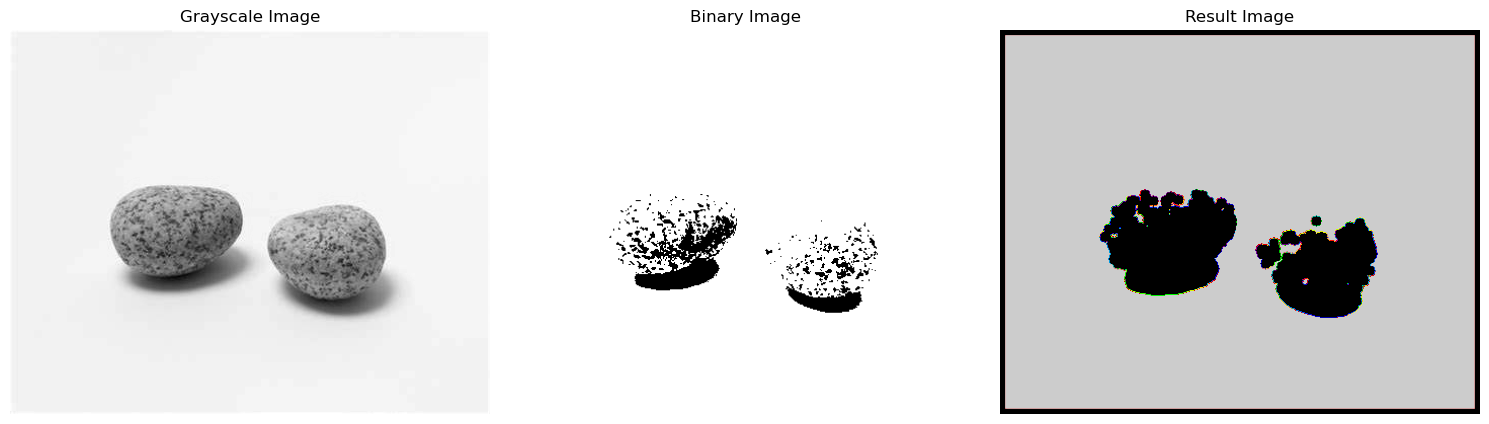

In [10]:
# Load
Path = 'Stones.jpeg'
image = plt.imread(Path)

# convert to grayscale
gray_scale_img = rgb_to_gray(image)

# to binary
binary_img = gray_to_binary(gray_scale_img)

# Define a structuring element using `disk`
ero_struct = disk(radius=5)

# Perform erosion operation
eroded_image = binary_erosion(binary_img, ero_struct)

# View results
plot_results(gray_scale_img, binary_img, eroded_image, path=Path, save=False)

## **Dilation Operation**

**Objective**: Perform binary dilation on a binary image.


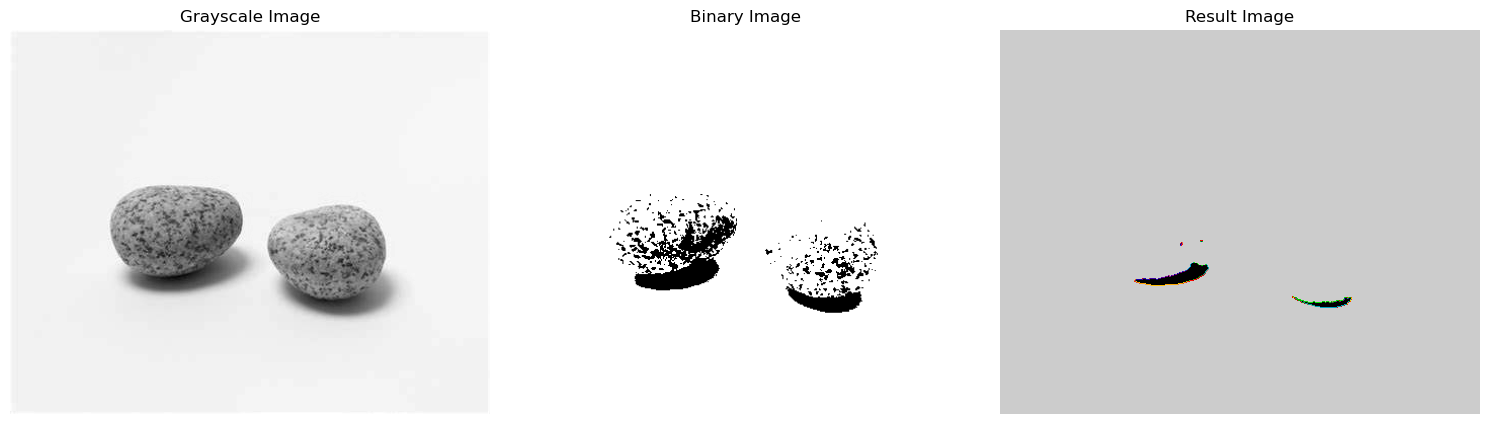

In [11]:
# Load
Path = 'Stones.jpeg'
image = plt.imread(Path)

# convert to grayscale
gray_scale_img = rgb_to_gray(image)

# to binary
binary_img = gray_to_binary(gray_scale_img)

# Define a structuring element using `disk`
dilation_struct = disk(radius=5)

# Perform erosion operation
dilated_image = binary_dilation(binary_img, dilation_struct)

# View results
plot_results(gray_scale_img, binary_img, dilated_image, path=Path, save=False)

## **Opening Operation**

**Objective**: Perform binary opening (erosion followed by dilation) on a binary image.


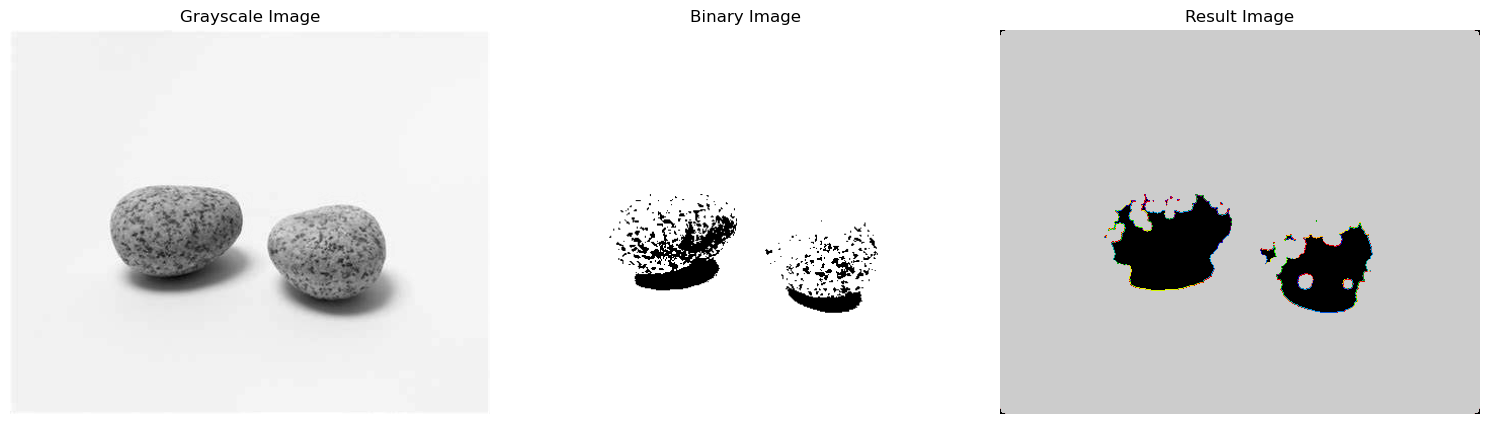

In [12]:
# Load
Path = 'Stones.jpeg'
image = plt.imread(Path)

# convert to grayscale
gray_scale_img = rgb_to_gray(image)

# to binary
binary_img = gray_to_binary(gray_scale_img)

# Define a structuring element using `disk`
opening_struct = disk(radius=5)

# Perform erosion operation
opened_image = binary_opening(binary_img, opening_struct)

# View results
plot_results(gray_scale_img, binary_img, opened_image, path=Path, save=False)

## **Closing Operation**

**Objective**: Perform binary closing (dilation followed by erosion) on a binary image.


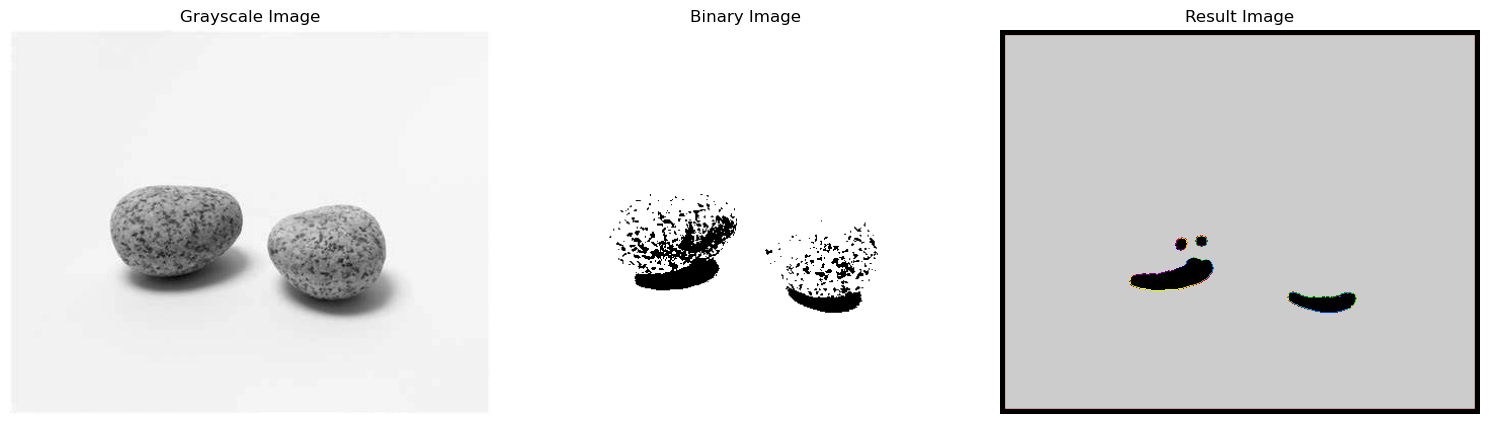

In [13]:
# Load
Path = 'Stones.jpeg'
image = plt.imread(Path)

# convert to grayscale
gray_scale_img = rgb_to_gray(image)

# to binary
binary_img = gray_to_binary(gray_scale_img)

# Define a structuring element using `disk`
closing_struct = disk(radius=5)

# Perform erosion operation
closed_image = binary_closing(binary_img, closing_struct)

# View results
plot_results(gray_scale_img, binary_img, closed_image, path=Path, save=False)

## **Morphological Gradient**

**Objective:** The morphological gradient aims to emphasize the boundaries of objects in a binary image by computing the difference between the dilation and erosion of the image using a structuring element.

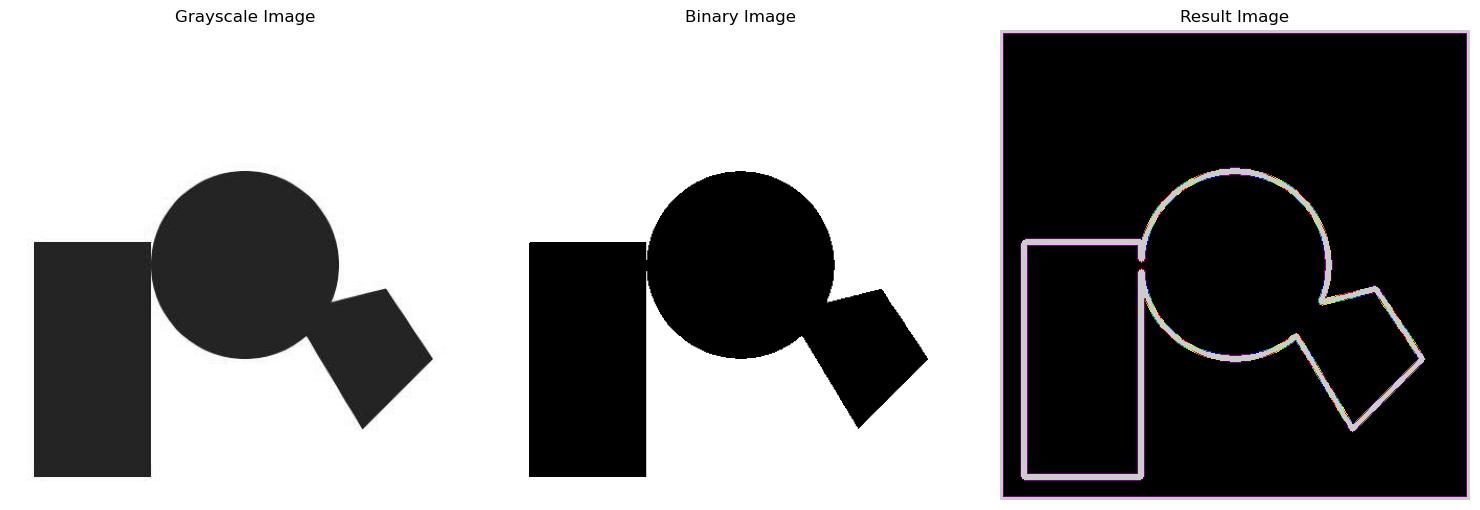

In [14]:
# Loading image
path = "custom_shapes.jpg"
image = plt.imread(path)

# Grayscale conversion
gray = rgb_to_gray(image)

# Binary conversion
binary_image = gray_to_binary(gray)

# Structuring element
morpho_struct = disk(3)

# Perform morphological gradient using custom function
custom_gradient = morphological_gradient(binary_image, morpho_struct)

plot_results(gray, binary_image, custom_gradient, path=path, color='nipy_spectral', save=True)

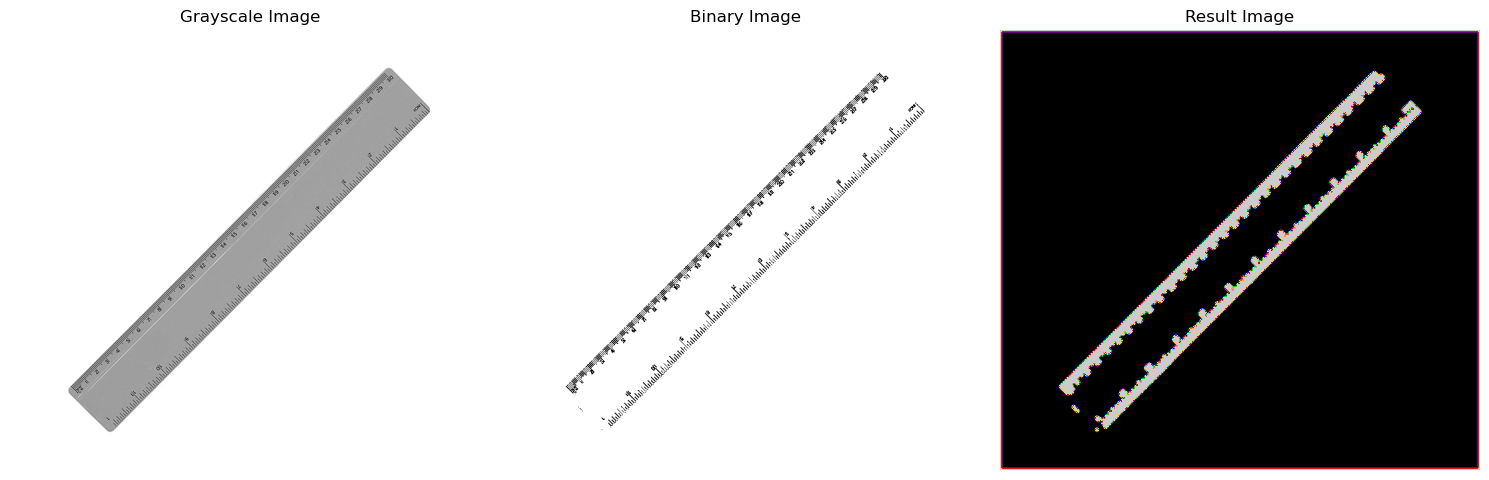

In [15]:
# Loading image
path = "Ruler.jpg"
image = plt.imread(path)

# Grayscale conversion
gray = rgb_to_gray(image)

# Binary conversion
binary_image = gray_to_binary(gray)

# Structuring element
morpho_struct = disk(3)

# Perform morphological gradient using custom function
custom_gradient = morphological_gradient(binary_image, morpho_struct)

plot_results(gray, binary_image, custom_gradient, path=path, color='nipy_spectral', save=True)


As seen from the results, the morphological gradient enhances the edges and boundaries of objects in the binary image. This enhancement is achieved by subtracting the result of erosion from dilation, effectively highlighting the transitions between foreground and background regions within the image.

## **Image Segmentation and Object Counting**

**Objective**: Segment objects in image and count the number of distinct objects present.

### **Example 1: Segmenting and Counting Stones**

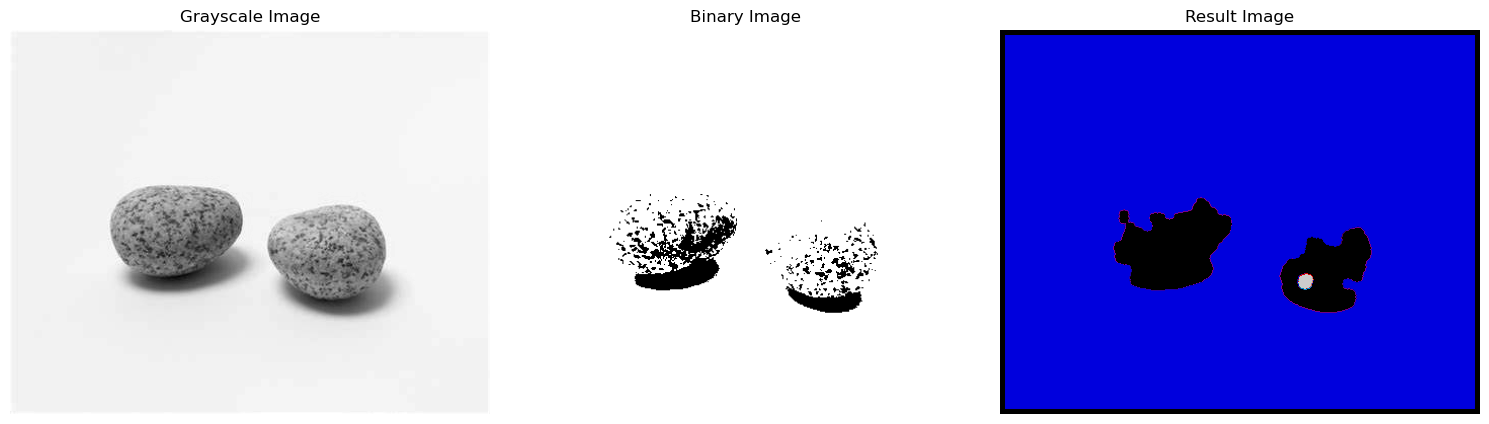

Number of distinct objects: 2


In [16]:
# Loadin image
path = 'Stones.jpeg'
image = plt.imread(path)

# Grayscale conversion
gray = rgb_to_gray(image)

# Binary conversion
binary_image = gray_to_binary(gray)

# Structuring element
selem = disk(5)

# Opening to remove small noise
opened_image = binary_opening(binary_image, selem)

# Closing to close small holes inside objects
closed_image = binary_closing(opened_image, selem)

# Labeled image and number of objects
labeled_image, num_objects = connected_components(closed_image)

plot_results(gray, binary_image, labeled_image, path=path, color='binary', save=True)

print(f'Number of distinct objects: {num_objects}')

### **Example 2: Segementing and Counting Rice Grains**

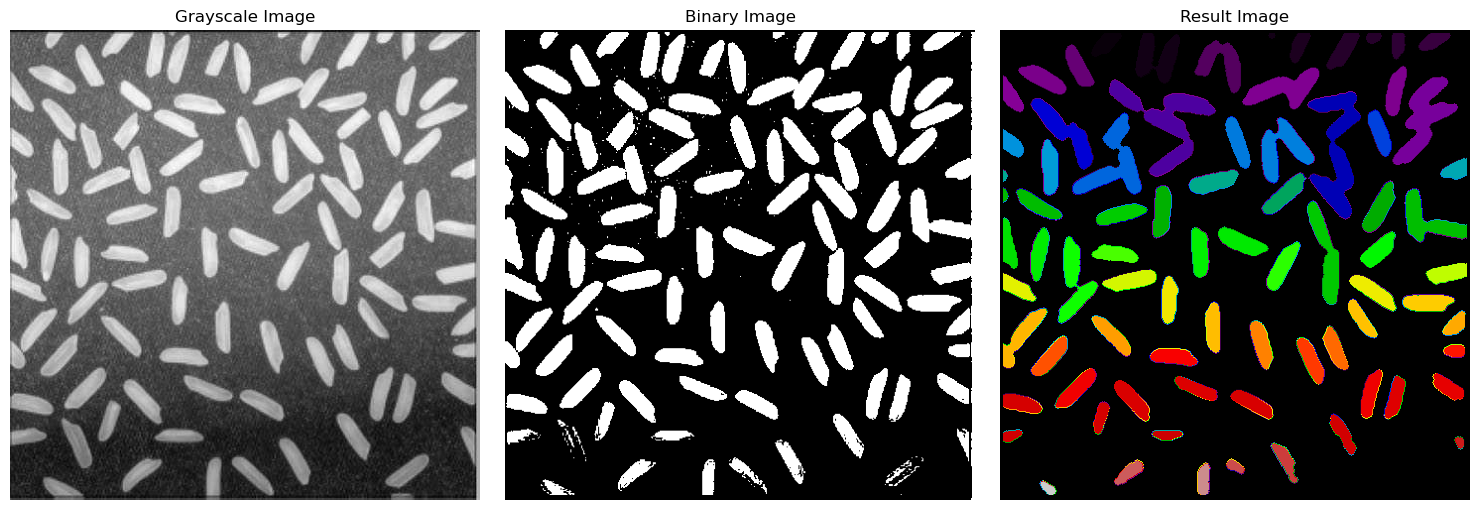

Number of distinct objects: 79


In [17]:
# Loadin image
path = 'rice.jpeg'
image = plt.imread(path)

# Grayscale conversion
gray = rgb_to_gray(image)

# Binary conversion
binary_image = gray_to_binary(gray)

# Structuring element
segment_struct2 = disk(3)

# Opening to remove small noise
opened_image = binary_opening(binary_image, segment_struct2)

# Closing to close small holes inside objects
closed_image = binary_closing(opened_image, segment_struct2)

# Labeled image and number of objects
labeled_image, num_objects = connected_components(closed_image)

plot_results(gray, binary_image, labeled_image, path=path, color='binary', save=False)

print(f'Number of distinct objects: {num_objects}')

## **Skeletonization**

**Objective:** Reduces binary objects to their skeletal form, essentially thin versions of the shapes in the image.

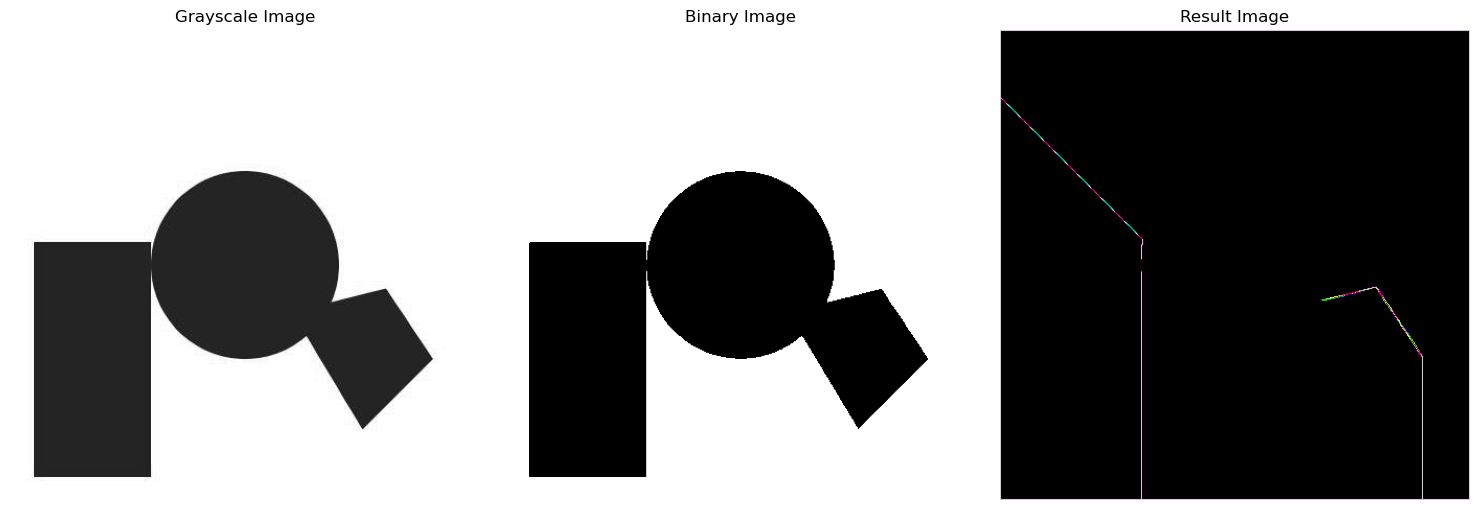

In [40]:
# Loading image
path = "custom_shapes.jpg"
image = plt.imread(path) 

# Convert the image to grayscale
gray_image = rgb_to_gray(image)

# Convert the grayscale image to binary
binary_image = gray_to_binary(gray_image)

# Perform skeletonization
custom_skeletonized_image = skeletonization(binary_image)

plot_results(gray_image, binary_image, custom_skeletonized_image, path=path, color='binary', save=True)